In [3]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
cap = cv2.VideoCapture(1)

In [5]:
def get_frame_rgb(cap):
    _, frame = cap.read()
    frame = np.copy(frame)
    #plt.imshow(frame)
    target_width = 450
    target_height = frame.shape[1] * target_width / frame.shape[0]
    frame1 = cv2.resize(frame, (target_height, target_width))
    framergb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    return framergb

In [38]:
def get_mask(framergb):
    frame2 = cv2.cvtColor(framergb, cv2.COLOR_BGR2HSV)
    
    lower_red = np.array([160,50,50])
    upper_red = np.array([179,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(frame2, lower_red, upper_red)

    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame2, frame2, mask = mask)
    #plt.imshow(mask)
    return mask

In [39]:
def get_keypoints(mask):
    #canvas = np.copy(framergb)

    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 100;

    # Filter by Area.
    params.filterByArea = False
    params.minArea = 1500

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(255-mask)

    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    #im_with_keypoints = cv2.drawKeypoints(canvas, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    points = [kp.pt for kp in keypoints]

    #plt.imshow(im_with_keypoints)
    return np.array(points)

In [175]:
%timeit cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)

10 loops, best of 3: 30 ms per loop


In [176]:
%timeit cv2.minMaxLoc(res)

1000 loops, best of 3: 416 µs per loop


In [156]:
img = get_mask(cv2.imread('tracking1.jpg'))
template = get_mask(cv2.imread('tracking2.jpg'))
template = template[200:400,100:300]
w, h = template.shape[::-1]
res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

In [157]:
res1 = img2[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]

In [161]:
old_top_left = np.array([100, 200.])

In [163]:
kp_new = get_keypoints(res1) + top_left
kp_old = get_keypoints(template) + top_left

In [164]:
canvas = np.zeros((img.shape + (3,)), dtype=np.float64)
canvas[:,:,1] = 0.
for pt in kp_new:
    pt = tuple([int(t) for t in pt])
    cv2.circle(canvas, pt, 3, (1., 0, 0), -1)
for pt in kp_old:
    pt = tuple([int(t) for t in pt])
    cv2.circle(canvas, pt, 3, (0, 1., 0), -1)

In [172]:
def draw_points(points, last_points, top_left, last_top_left, framergb):
    def coords_to_cv(p):
        return tuple([int(t) for t in p])
    def get_dist(p1, p2):
        return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2
    canvas = np.copy(framergb)
    assigned_indices = []
    distances = []
    for p in points:
        min_i = -1
        for i, p1 in enumerate(last_points):
            if min_i == -1:
                min_i = i
            dist = get_dist(last_points[i], p)
            min_dist = get_dist(last_points[min_i], p)
            if dist < min_dist:
                min_i = i
        distances.append(get_dist(last_points[min_i], p))
        assigned_indices.append(min_i)
        
    th = np.mean(distances)
        
    for i in range(len(points)):
        p = points[i]
        dist = distances[i]
        p1 = last_points[assigned_indices[i]] + last_top_left - top_left
        if dist <= th:
            cv2.line(canvas, coords_to_cv(p1), coords_to_cv(p), (0, 255, 0))
            cv2.circle(canvas, coords_to_cv(p), 3, (0, 0, 255))
    return canvas

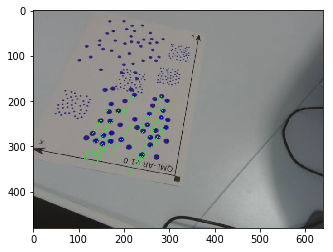

In [173]:
framergb = cv2.imread('tracking1.jpg')
plt.imshow(draw_points(kp_new, kp_old, top_left, old_top_left, framergb))